In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda, Dense, Input

from keras.callbacks import ModelCheckpoint 

from keras import optimizers
from keras import backend as K
from keras import regularizers

#from sklearn.model_selection import train_test_split
#from sklearn.datasets import load_files 
from tqdm import tqdm

# Add real time loss and accuracy plot
from livelossplot import PlotLossesKeras

# Load and examine the dataset

In [3]:
def load_dataset(path):
    # the sklearn.datasets.load_files function takes a dataset directory as an input
    # for each folder within the directory, the folder name should be a category
    # within each folder will be samples corresponding to their category
    # load_files returns a bunch object which is a dictionary with 'DESC', 
    # 'data', 'filenames', 'target' as keys
    data = load_files(path)
    # an array of file paths or directories
    data_files = np.array(data['filenames']) 
    data_labels = np_utils.to_categorical(np.array(data['target']), 10)
    return data_files, data_labels

In [4]:
train_data_dir = "train/"
faked_data_dir = "faked/"
data_directory = faked_data_dir

In [5]:
train_files, train_labels = load_dataset(data_directory)
print("There are {} total training images.".format(len(train_files)))

There are 20 total training images.


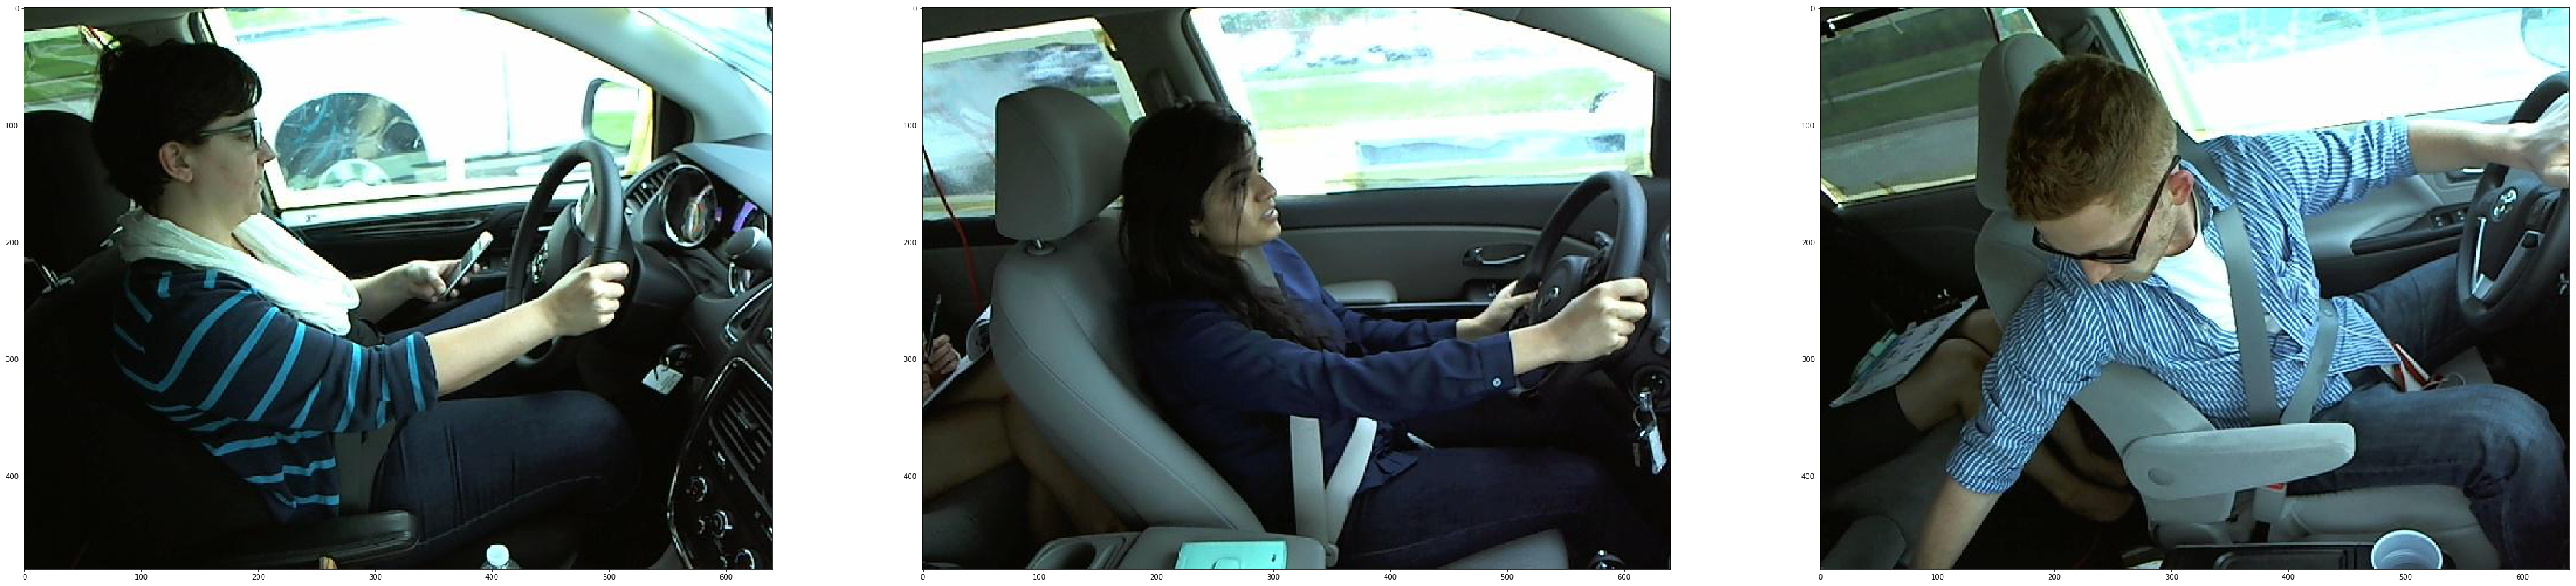

In [6]:
# Random visualize some image data
samples = np.random.choice(train_files, 3)
imgs = []
for sample in samples: 
    img = mpimg.imread(sample)
    imgs.append(img)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(64, 48))
ax1.imshow(imgs[0])
ax2.imshow(imgs[1])
ax3.imshow(imgs[2])
plt.show()

# Model building

<div class="alert alert-info">**Note:** In order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.
</div>

### InceptionV3

In [7]:
# Hyperparameters setting
batch_size = 2
bottleneck_epochs = 5
finetune_epochs = 5
target_size = (299, 299)

In [ ]:
# This cell demonstrate how to split the dataset with Sklearn, but I prefer ImageDataGenerator
# X_train, X_valid, y_train, y_valid = train_test_split(train_files, train_labels, test_size=0.2)

In [ ]:
#y_train

In [ ]:
#X_train_data = paths_to_tensor(X_train, target_size=target_size)
#X_valid_data = paths_to_tensor(X_valid, target_size=target_size)

In [ ]:
#X_train_data = preprocess_input(X_train_data)
#X_valid_data = preprocess_input(X_valid_data)

In [ ]:
#bottleneck_features_train = InceptionV3_model.predict(X_train_data, verbose=1)
#bottleneck_features_validation = InceptionV3_model.predict(X_valid_data, verbose=1)

#np.savez('bottleneck_features_train.npz', 
#         train=bottleneck_features_train, 
#         validation=bottleneck_features_validation)

In [ ]:
#bottleneck_features = np.load('bottleneck_features_train.npz')
#train_data = bottleneck_features['train']
#validation_data = bottleneck_features['validation']

In [9]:
# Here I want to try real time data augumentation with keras
# `validation_split` is only support in Keras 2.2.0 
train_valid_datagen = ImageDataGenerator(zoom_range=0.2, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   preprocessing_function=preprocess_input, 
                                   validation_split=0.2)

In [10]:
# `subset` is only possible if `validation_split` is set
train_generator = train_valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=target_size, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="training",
                                                    shuffle=True)

Found 20 images belonging to 10 classes.


In [11]:
# `subset` is only possible if `validation_split` is set
validation_generator = train_valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=target_size, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="validation",
                                                    shuffle=True)

Found 0 images belonging to 10 classes.


In [13]:
# Better provide the input shape to made the model summary more readible
input_tensor = Input(shape=(299, 299, 3))

InceptionV3_base = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = InceptionV3_base.output
# The input shape from bottleneck_feature is (data_size, 8, 8, 2048)
x = GlobalAveragePooling2D()(x) #1x1x2048
x = Dense(512, activation='relu')(x) #1x1x512
x = Dense(10, name='top')(x) #1x1x10
#x = Dense(10, name='top', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01))(x)
# I use below line instead of normal softmax to bypass the compatibility issues.
predictions = Lambda(lambda x: K.tf.nn.softmax(x))(x)

InceptionV3_model = Model(inputs=InceptionV3_base.input, outputs=predictions)

for layer in InceptionV3_base.layers:
    layer.trainable = False

# print out layer names to help decide where to unfreeze
for i, layer in enumerate(InceptionV3_base.layers):
    print(i, layer.name)

InceptionV3_model.summary()

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

activation_108 (Activation)     (None, 35, 35, 48)   0           batch_normalization_108[0][0]    
__________________________________________________________________________________________________
activation_111 (Activation)     (None, 35, 35, 96)   0           batch_normalization_111[0][0]    
__________________________________________________________________________________________________
average_pooling2d_11 (AveragePo (None, 35, 35, 256)  0           mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 35, 35, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 35, 35, 64)   76800       activation_108[0][0]             
__________________________________________________________________________________________________
conv2d_112

batch_normalization_133 (BatchN (None, 17, 17, 192)  576         conv2d_133[0][0]                 
__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, 17, 17, 192)  576         conv2d_134[0][0]                 
__________________________________________________________________________________________________
activation_125 (Activation)     (None, 17, 17, 192)  0           batch_normalization_125[0][0]    
__________________________________________________________________________________________________
activation_128 (Activation)     (None, 17, 17, 192)  0           batch_normalization_128[0][0]    
__________________________________________________________________________________________________
activation_133 (Activation)     (None, 17, 17, 192)  0           batch_normalization_133[0][0]    
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 17, 17, 192)  258048      activation_160[0][0]             
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 17, 17, 192)  576         conv2d_156[0][0]                 
__________________________________________________________________________________________________
batch_normalization_161 (BatchN (None, 17, 17, 192)  576         conv2d_161[0][0]                 
__________________________________________________________________________________________________
activation_156 (Activation)     (None, 17, 17, 192)  0           batch_normalization_156[0][0]    
__________________________________________________________________________________________________
activation_161 (Activation)     (None, 17, 17, 192)  0           batch_normalization_161[0][0]    
__________

__________________________________________________________________________________________________
batch_normalization_184 (BatchN (None, 8, 8, 448)    1344        conv2d_184[0][0]                 
__________________________________________________________________________________________________
activation_184 (Activation)     (None, 8, 8, 448)    0           batch_normalization_184[0][0]    
__________________________________________________________________________________________________
conv2d_181 (Conv2D)             (None, 8, 8, 384)    786432      mixed9[0][0]                     
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 8, 8, 384)    1548288     activation_184[0][0]             
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 8, 8, 384)    1152        conv2d_181[0][0]                 
__________

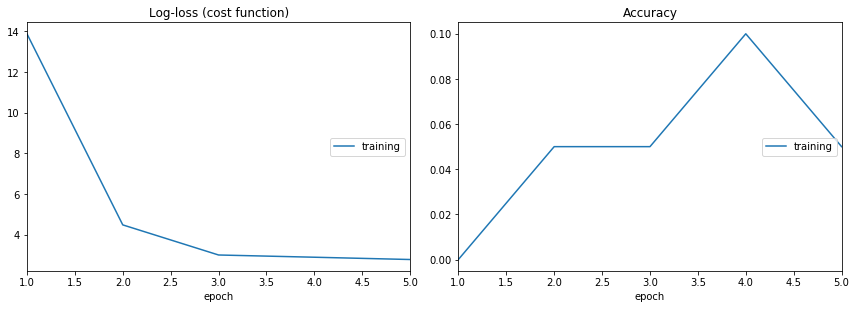

In [14]:
# Compile the mode, with optimizer as `rmsprop`
InceptionV3_model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Set checkpointer for training callbacks
checkpointer = ModelCheckpoint(filepath='InceptionV3_pretrain_weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Here I am ploting the losses and accuracy in real time
history = InceptionV3_model.fit_generator(train_generator,
                    validation_data=validation_generator, 
                    epochs=bottleneck_epochs, 
                    callbacks=[checkpointer, PlotLossesKeras()], 
                    verbose=0)

In [ ]:
# Visualizing the losses and accuracies manually
# This now became useless since I found the realtime loss display solution

# Loss Curves
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#ax1.plot(history.history['loss'], 'r', linewidth=2.0)
#ax1.plot(history.history['val_loss'], 'b', linewidth=2.0)
#ax1.legend(['Training loss', 'Validation loss'], fontsize=18)
#ax1.set_xlabel('Epochs ', fontsize=16)
#ax1.set_ylabel('Loss', fontsize=16)
#ax1.set_title('Loss Curvers', fontsize=16)

# Accuracy Curves
#ax2.plot(history.history['acc'], 'r', linewidth=2.0)
#ax2.plot(history.history['val_acc'], 'b', linewidth=2.0)
#ax2.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
#ax2.set_xlabel('Epochs ', fontsize=16)
#ax2.set_ylabel('Accuracy', fontsize=16)
#ax2.set_title('Accuracy Curvers', fontsize=16);

In [ ]:
# This cell is just to illustrate how to examine the training result manually
#model.load_weights('saved_models/bottleneck_weights.best.hdf5')
# get index of predictions each image in test set
#predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in validation_data]

# report test accuracy
#validation_accuracy = 100 * np.sum(np.array(predictions)==np.argmax(y_valid, axis=1))/len(predictions)

#print("Test accuracy: {:.4f}%".format(validation_accuracy))

# Finetuning the model 

I run into [this link](https://keras.io/applications/) and rewrite my finetuning model as below

In [ ]:
# In case the finetune process fails, run this line to start over
# InceptionV3_model.load_weights('InceptionV3_pretrain_weights.best.hdf5')

In [ ]:
for layer in InceptionV3_model.layers[:249]:
    layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
    layer.trainable=True

InceptionV3_model.summary()

In [ ]:
# Train the model with SGD and small learning rate to REALLY FINETUNE
InceptionV3_model.compile(optimizer=optimizers.SGD(lr=1e-5, momentum=0.5), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='InceptionV3_finetune_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

tuning_history = InceptionV3_model.fit_generator(train_generator, 
                            epochs=finetune_epochs, 
                            validation_data=validation_generator, 
                            callbacks=[checkpointer, PlotLossesKeras()], 
                            verbose=1)

In [ ]:
# Visualizing the losses and accuracies

# Loss Curves
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#ax1.plot(tuning_history.history['loss'], 'r', linewidth=2.0)
#ax1.plot(tuning_history.history['val_loss'], 'b', linewidth=2.0)
#ax1.legend(['Training loss', 'Validation loss'], fontsize=18)
#ax1.set_xlabel('Epochs ', fontsize=16)
#ax1.set_ylabel('Loss', fontsize=16)
#ax1.set_title('Loss Curvers', fontsize=16)

# Accuracy Curves
#ax2.plot(tuning_history.history['acc'], 'r', linewidth=2.0)
#ax2.plot(tuning_history.history['val_acc'], 'b', linewidth=2.0)
#ax2.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
#ax2.set_xlabel('Epochs ', fontsize=16)
#ax2.set_ylabel('Accuracy', fontsize=16)
#ax2.set_title('Accuracy Curvers', fontsize=16);

## Ensemble models

I personally don't like the idea of Ensemble since it is more of a competition wining skills which only add the complexity of the model and can hardly be used in production. However, as a learning experience, I want to give it a try. 

In [8]:
# Helper functions to process the test data
def path_to_tensor(img_path, target_size=target_size):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, target_size=target_size):
    list_of_tensors = [path_to_tensor(path, target_size=target_size) for path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
from keras.applications.inception_v3 import preprocess_input as Inception_preprocess
from keras.applications.resnet50 import preprocess_input as Resnet_preprocess
from glob import glob
from collections import defaultdict
import pandas as pd

img_names = [item[5:] for item in sorted(glob('test/*'))]
img_directory = [item for item in sorted(glob('test/*'))]

Inception_data = paths_to_tensor(img_directory, target_size=(299, 299))
Resnet50_data = paths_to_tensor(img_directory, target_size=(224, 224))

Inception_input = Inception_preprocess(Inception_data)
Resnet50_input = Resnet_preprocess(Resnet50_data)

In [ ]:
# Obtain the ensembled predictions
# Here I used tuning twice for test's sake

predictions = defaultdict(np.array)

for img_name, inception, resnet in zip(img_names, Inception_input, Resnet50_input):
    Inception_output = InceptionV3_model.predict(np.expand_dims(inception, 0))
    Resnet_output = resnet_tuning.predict(np.expand_dims(inception, 0))
    ensembled = np.mean(np.vstack((Inception_output, Resnet_output)), axis=0)
    predictions[img_name] = ensembled

In [ ]:
# Write out the data according to submission request format

data = pd.DataFrame(predictions, index=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
data = data.transpose()
data

In [ ]:
data.to_csv("my data.csv")